# K-NN

K-NN算法实现

(150, 4)
(150, 2)
(150,)


D:\miniconda3\install\envs\python36\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


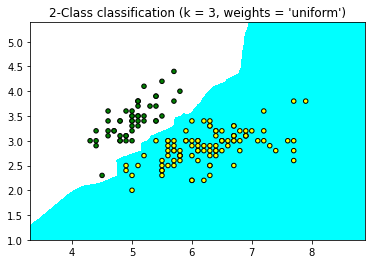

In [27]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 3   #k=1时为最近邻

iris = datasets.load_iris()  

print(iris.data.shape)   #鸢尾花数据特征的shape（150，4）
X = iris.data[:, 0:2]   #导入鸢尾花数据的两个特征（总共4个特征）
print(X.shape)
y = iris.target   #鸢尾花的分类标签
print(y.shape)  #（150，）

h = 0.01  # 网格的精密程度

#作图颜色
cmap_light = ListedColormap(['white', 'cyan'])
cmap_bold = ListedColormap(['green', 'yellow'])

for weights in ['uniform']:  #基于uniform的最近邻算法拟合
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # 网格作图
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  #图框边缘冗余1的宽度
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # 将分类的结果用不同颜色表示区域
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # 将训练的点画在相应的分类区域内
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

KD树搜索算法实现

In [1]:
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split  # 整数（进行分割维度的序号）
        self.left = left  # 该结点分割超平面左子空间构成的kd-tree
        self.right = right  # 该结点分割超平面右子空间构成的kd-tree


class KdTree(object):
    def __init__(self, data):
        k = len(data[0])  # 数据维度

        def CreateNode(split, data_set):  # 按第split维划分数据集exset创建KdNode
            if not data_set:  # 数据集为空
                return None
            # key参数的值为一个函数，此函数只有一个参数且返回一个值用来进行比较
            # operator模块提供的itemgetter函数用于获取对象的哪些维的数据，参数为需要获取的数据在对象中的序号
            #data_set.sort(key=itemgetter(split)) # 按要进行分割的那一维数据排序
            data_set.sort(key=lambda x: x[split])
            split_pos = len(data_set) // 2  # //为Python中的整数除法
            median = data_set[split_pos]  # 中位数分割点
            split_next = (split + 1) % k  # cycle coordinates

            # 递归的创建kd树
            return KdNode(
                median,
                split,
                CreateNode(split_next, data_set[:split_pos]),  # 创建左子树
                CreateNode(split_next, data_set[split_pos + 1:]))  # 创建右子树

        self.root = CreateNode(0, data)  # 从第0维分量开始构建kd树,返回根节点


# KDTree的前序遍历
def preorder(root):
    print(root.dom_elt)
    if root.left:  # 节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [2]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple",
                    "nearest_point  nearest_dist  nodes_visited")


def find_nearest(tree, point):
    k = len(point)  # 数据维度

    def travel(kd_node, target, max_dist):
        if kd_node is None:
            return result([0] * k, float("inf"),
                          0)  # python中用float("inf")和float("-inf")表示正负无穷

        nodes_visited = 1

        s = kd_node.split  # 进行分割的维度
        pivot = kd_node.dom_elt  # 进行分割的“轴”

        if target[s] <= pivot[s]:  # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node = kd_node.left  # 下一个访问节点为左子树根节点
            further_node = kd_node.right  # 同时记录下右子树
        else:  # 目标离右子树更近
            nearer_node = kd_node.right  # 下一个访问节点为右子树根节点
            further_node = kd_node.left

        temp1 = travel(nearer_node, target, max_dist)  # 进行遍历找到包含目标点的区域

        nearest = temp1.nearest_point  # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist  # 更新最近距离

        nodes_visited += temp1.nodes_visited

        if dist < max_dist:
            max_dist = dist  # 最近点将在以目标点为球心，max_dist为半径的超球体内

        temp_dist = abs(pivot[s] - target[s])  # 第s维上目标点与分割超平面的距离
        if max_dist < temp_dist:  # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited)  # 不相交则可以直接返回，不用继续判断

        #----------------------------------------------------------------------
        # 计算目标点与分割点的欧氏距离
        temp_dist = sqrt(sum((p1 - p2)**2 for p1, p2 in zip(pivot, target)))

        if temp_dist < dist:  # 如果“更近”
            nearest = pivot  # 更新最近点
            dist = temp_dist  # 更新最近距离
            max_dist = dist  # 更新超球体半径

        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)

        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist:  # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point  # 更新最近点
            dist = temp2.nearest_dist  # 更新最近距离

        return result(nearest, dist, nodes_visited)

    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

In [3]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]
